# DTSA5510 FINAL PROJECT - Unsupervised Learning

This project is about applying unsupervised learning to make news recommendation

## Step 1 - Gather data, determine the method of data collection and provenance of the data

**The dataset I chose is the Microsoft News Dataset called MIND. MIND is a large-scale English dataset for news recommendation research. It contains approximately 160k English news articles and more than 15 million impression logs generated by 1 million users who had at least 5 news clicks during 6 weeks from October 12 to November 22, 2019.**

**Instead of the full dataset, I aim to work with a small version of the MIND dataset, which contains a sample of 50,000 users and their behavior logs from the MIND dataset. I downloaded the MIND-small dataset from https://msnews.github.io. The MIND-small dataset contains a training set and validation set totaling about 247MB.**

## Step 2 - Identify an Unsupervised Learning Problem

**The problem I am aiming to solve is to build a recommendation model for news articles. The dataset includes information about users and their clicks on different news articles. Clicking on a news article is considered a positive rating. Since each user has only a few clicks compared to all the news in the corpus, this is a classic unsupervised learning problem. The goal is to predict their clicks on news articles they may be interested in based on all the other users' clicks on different news articles. This machine learning model development will involve the following techniques:**
- **Word embeddings: For example, Doc2Vec and TF-IDF to generate a vector representation of the news articles.**
- **Item-to-Item analysis: For example, cosine similarity and Euclidean distance to determine similarity between news articles.**
- **Collaborative filtering-based recommendation based on users' clicks on news articles.**

## Step 3 - Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data


### Step 3.1 - Describe the factors or components that make up the dataset (The "factors" here are called "features" in the machine learning term. These factors are often columns in the tabulated data). For each factor, use a box-plot, scatter plot, histogram, etc., to describe the data distribution as appropriate. 

**The small version of the MIND dataset consists of two folders: one for training data and one for testing data. Each folder contains four files: behaviors, news, entity_embedding, and relation_embedding. Due to time limitations for this project, I will only be using the news and behaviors TSV files.**
- behaviors.tsv >> The click histories and impression logs of users
- news.tsv >> The information of news articles
- entity_embedding.vec	 >> The embeddings of entities in news extracted from knowledge graph
- relation_embedding.vec >> The embeddings of relations between entities extracted from knowledge graphaph


In [73]:
import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd

# Load the TSA file into a DataFrame
train_news = pd.read_csv(
    "Data/MINDsmall_train/news.tsv", 
    sep="\t",
    names=["itemId","category","subcategory","title","abstract","url","title_entities","abstract_entities"])
train_user = pd.read_csv(
    "Data/MINDsmall_train/behaviors.tsv", 
    sep="\t",
    names=["impressionId","userId","timestamp","click_history","impressions"])
#train_entity = pd.read_csv('Data/MINDsmall_train/entity_embedding.vec', sep='\t')
#train_relation = pd.read_csv('Data/MINDsmall_train/relation_embedding.vec', sep='\t')
test_news = pd.read_csv(
    "Data/MINDsmall_dev/news.tsv", 
    sep="\t",
    names=["itemId","category","subcategory","title","abstract","url","title_entities","abstract_entities"])
test_user = pd.read_csv(
    "Data/MINDsmall_dev/behaviors.tsv", 
    sep="\t",
    names=["impressionId","userId","timestamp","click_history","impressions"])
#test_entity = pd.read_csv('Data/MINDsmall_dev/entity_embedding.vec', sep='\t')
#test_relation = pd.read_csv('Data/MINDsmall_dev/relation_embedding.vec', sep='\t')

### The Behavior table

**Below is the summary and sample rows of the behavior table.  There are a total of 156965 rows showing individual impressions presented to users.  Each impression has a number of articles.**  

**The behaviors.tsv file contains the impression logs and users' news click hostories. It has 5 columns divided by the tab symbol:**
- Impression ID. The ID of an impression.
- User ID. The anonymous ID of a user.
- Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
- History. The news click history (ID list of clicked news) of this user before this impression. The clicked news articles are ordered by time.
- Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click). The orders of news in a impressions have been shuffled.ffled.

In [7]:
print('Training Behaviors')
print(train_user.info())
train_user.head()

Training Behaviors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   impressionId   156965 non-null  int64 
 1   userId         156965 non-null  object
 2   timestamp      156965 non-null  object
 3   click_history  153727 non-null  object
 4   impressions    156965 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB
None


,impressionId,userId,timestamp,click_history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [8]:
train_user_count = train_user.groupby('userId').count()
print('Total number of unique users: ', len(train_user_count))
print('Average number of impression per user: ',train_user_count['impressionId'].mean())

Total number of unique users:  50000
Average number of impression per user:  3.1393


**Based on the average of the 50,000 users in the dataset, they have approximately 3.14 impressions on average, as depicted in the histogram below. A significant portion of users have only a minimal number of impressions, leading to a majority of them having very few clicks on news articles. This could pose an issue for recommendation system modeling, as most users have only one or two clicks across all the news articles in the dataset.**

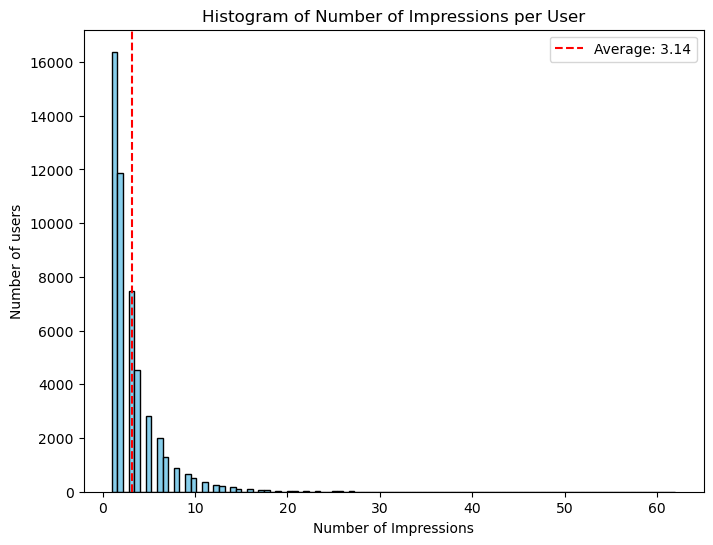

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Set the figure size
plt.hist(train_user_count['impressionId'], bins=100, color='skyblue', edgecolor='black')

plt.xlabel('Number of Impressions')
plt.ylabel('Number of users')
plt.title('Histogram of Number of Impressions per User')

# Plot vertical line for average
average_value = train_user_count['impressionId'].mean()
plt.axvline(x=average_value, color='red', linestyle='--', label=f'Average: {average_value:.2f}')
# Add legend
plt.legend()
plt.show()

### The News table
**Below is the summary the news table. There are a total of 51282 news (rows) in this dataset.** 

**The docs.tsv file contains the detailed information of news articles involved in the behaviors.tsv file. It has 8 columns, which are divided by the tab symbol:**
- News ID
- Category
- SubCategory
- Title
- Abstract
- URL
- Title Entities (entities contained in the title of this news)
- Abstract Entities (entites contained in the abstract of this news)

In [10]:
#train_news
print(train_news.info())
train_news.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   itemId             51282 non-null  object
 1   category           51282 non-null  object
 2   subcategory        51282 non-null  object
 3   title              51282 non-null  object
 4   abstract           48616 non-null  object
 5   url                51282 non-null  object
 6   title_entities     51279 non-null  object
 7   abstract_entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB
None


,itemId,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [11]:
train_news_category = train_news.groupby('category').count()
print('Total number of category: ', len(train_news_category.index))
print("Maximum number of news articles from category:", train_news_category['itemId'].max())
print("Minimum number of news articles from category:", train_news_category['itemId'].min())
print("Average number of news articles from category:", train_news_category['itemId'].mean())

Total number of category:  17
Maximum number of news articles from category: 15774
Minimum number of news articles from category: 1
Average number of news articles from category: 3016.5882352941176


**Below is a bar chart fot the categories.  There are a total 17 new categories.**

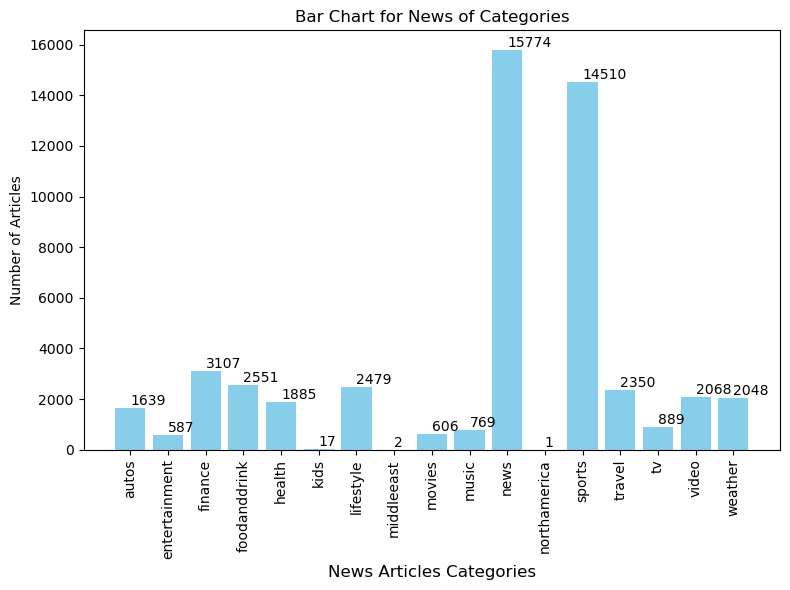

In [12]:
import matplotlib.pyplot as plt

# Sample categorical data
categories = train_news_category.index
values = train_news_category['itemId']

# Create bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color='skyblue')

# Add labels and title
plt.xlabel('News Articles Categories', fontsize=12)
plt.ylabel('Number of Articles')
plt.title('Bar Chart for News of Categories')
plt.xticks(rotation='vertical')

# Show the y value explicitly for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

### Step 3.2 - You should determine if your data has outliers or needs to be cleaned in any way. Are there missing data values for specific factors? How will you handle the data cleaning? Will you discard, interpolate or otherwise substitute data values?


### Cleaning up Nan Value

**Some rows has Nan value in train_news table's 'abstract' column.  For example, see the row 38 below.**

In [13]:
train_news.iloc[38]

itemId                                                          N22028
category                                                     lifestyle
subcategory                                              lifestylebuzz
title                Mom with schizophrenia, 6-year-old daughter mi...
abstract                                                           NaN
url                      https://assets.msn.com/labs/mind/AAJfTsZ.html
title_entities       [{"Label": "Queens", "Type": "G", "WikidataId"...
abstract_entities                                                   []
Name: 38, dtype: object

**I use the code below to copy the content from the 'title' column to the 'abstract' column because I need to use the content in the 'abstract' column for the word embeddings.**

In [14]:
# copying the content in 'title' to 'abstract' column in case of NaN
train_news['abstract'].fillna(train_news['title'], inplace=True)

**There are still more missing value in the both train_user and train_news table as shown below.** 

In [15]:
def check_missing(df): 
    for i, d in enumerate(df):
        df_name = [name for name, obj in globals().items() if obj is d][0]
        # Using isna() method
        nan_values = d.isna().sum()
        # Using isnull() method
        nan_values = d.isnull().sum()
        if d.isna().values.any():
            print(df_name, "table contains NaN values")
        else:
            print(df_name, "table does not contain any NaN values")
        # If you want to get the rows with NaN values
        rows_with_nan = d[d.isna().any(axis=1)]
        print(rows_with_nan)

check_missing([train_news, train_user])

train_news table contains NaN values
       itemId   category                      subcategory  \
2173   N49553  lifestyle  lifestylefamilyandrelationships   
16459  N20922    finance                    finance-video   
19834  N18259     sports                     football_nfl   
50811  N16590      video                             news   

                                                   title  \
2173            The 50 Most Common Last Names in America   
16459  The Price You Pay: The spiraling cost of colle...   
19834  Baker Mayfield injury update: 'No doubt' Brown...   
50811  Transcripts highlight Sean Hannity's political...   

                                                abstract  \
2173   What's in a name?\thttps://assets.msn.com/labs...   
16459      https://assets.msn.com/labs/mind/AAIKUGl.html   
19834  He'll be in better shape physically and he'll ...   
50811  We're seeing really disturbing things coming o...   

                                                     ur

I use the following code to remove users impressions that has no click_history. 

In [16]:
# Remove rows with NaN values
train_user.dropna(inplace=True)
train_news.dropna(inplace=True)

# Reset the index after removing rows
train_user.reset_index(drop=True, inplace=True)
train_news.reset_index(drop=True, inplace=True)

**The User and News tables no longer have any NaN values after cleaning as shown below.**

In [17]:
def check_missing(df): 
    for i, d in enumerate(df):
        df_name = [name for name, obj in globals().items() if obj is d][0]
        # Using isna() method
        nan_values = d.isna().sum()
        # Using isnull() method
        nan_values = d.isnull().sum()
        if d.isna().values.any():
            print(df_name, "table contains NaN values")
        else:
            print(df_name, "table does not contain any NaN values")
        # If you want to get the rows with NaN values
        rows_with_nan = d[d.isna().any(axis=1)]
        print(rows_with_nan)

check_missing([train_news, train_user])

train_news table does not contain any NaN values
Empty DataFrame
Columns: [itemId, category, subcategory, title, abstract, url, title_entities, abstract_entities]
Index: []
train_user table does not contain any NaN values
Empty DataFrame
Columns: [impressionId, userId, timestamp, click_history, impressions]
Index: []


### Step 3.3 - Determine if any data needs to be transformed. For example, if you're planning on using an SVM method for prediction, you may need to normalize or scale the data if there is a considerable difference in the range of the data.

### Extract information from 'click_history' and 'impressions' column

**The behavior table (train_user) definitely needs transformation. Both the "click_history" and "impressions" columns contain lists of news article items. These clicks and impressions are crucial data for generating user-item interaction data to feed machine learning models. I utilize the following code to count the number of news items for both the 'click_history' and 'impressions' columns and append the results to two new columns, 'click_history_count' and 'impressions_count', respectively.**

In [18]:
# count the number of news articles each user clicked
train_user['click_history_count'] = train_user.apply(lambda row: len(row['click_history'].split()), axis=1)
# count the number of impressions (articles showed in the same impression)
train_user['impressions_count'] = train_user.apply(lambda row: len(row['impressions'].split()), axis=1)

In [19]:
train_user.head()

,impressionId,userId,timestamp,click_history,impressions,click_history_count,impressions_count
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,9,2
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,82,11
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,16,36
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,10,4
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,4,69


**The following histogram displays the average number of news clicks per user across the entire dataset. The average news click is 104. The majority of users have just a handful of clicks. The maximum number of clicks by a user is 18,972, which may be an outlier.**

average click across all users:  104.00828785533925


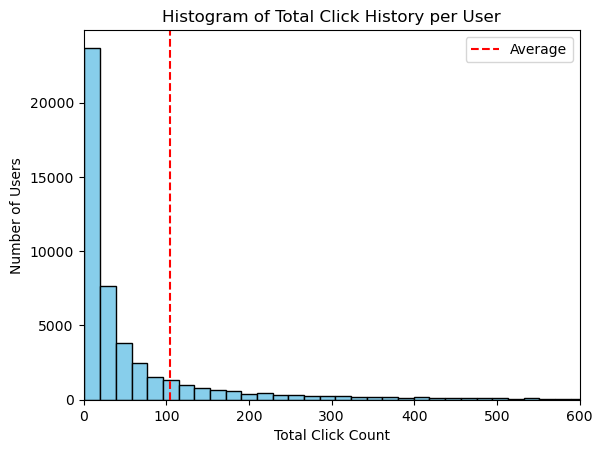

In [20]:
import numpy as np
import matplotlib.pyplot as plt
total_click_per_user = train_user.groupby('userId')['click_history_count'].sum()
print('average click across all users: ', np.mean(total_click_per_user))  # average click of all users

plt.hist(total_click_per_user, bins=1000, color='skyblue', edgecolor='black')
# Add labels and title
plt.xlabel('Total Click Count')
plt.ylabel('Number of Users')
plt.title('Histogram of Total Click History per User')
plt.xlim(0, 600)
# Plot vertical line for average
plt.axvline(x=np.mean(total_click_per_user), color='red', linestyle='--', label='Average')
# Add legend
plt.legend()
# Show plot
plt.show()

In [21]:
print("Maximum number of click from a user:", total_click_per_user.max())
print("Minimum number of click from a user:", total_click_per_user.min())
print("Average number of click from a user:", total_click_per_user.mean())

Maximum number of click from a user: 18972
Minimum number of click from a user: 1
Average number of click from a user: 104.00828785533925


### Step 3.4 - Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated. You may use numeric or qualitative/graphical analysis for this step.

**I have an assumption that the click_history_count is positively correlated to impressions_count because the more impressions a news article receives, the more likely users are to click on it, resulting in a higher click_history count. The following graph does show that the average 'click_history_count' per user is at least slightly positively related to the average 'impressions_count' per user.**

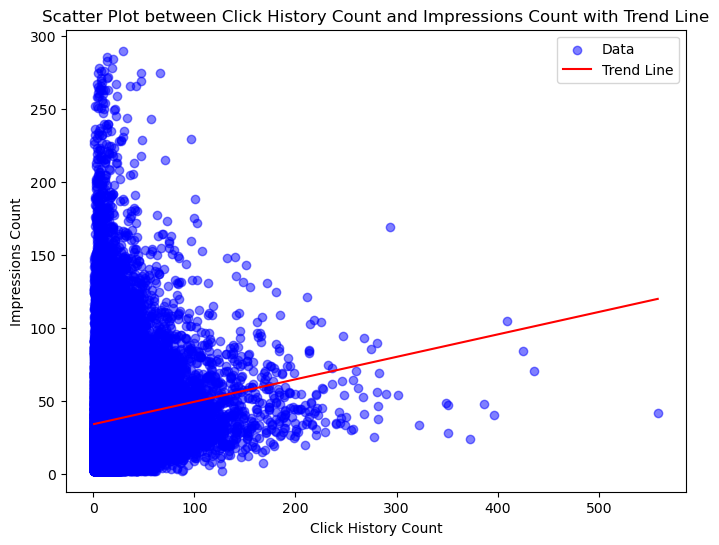

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Extracting data
x = train_user.groupby('userId')['click_history_count'].mean()
y = train_user.groupby('userId')['impressions_count'].mean()

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.5, label='Data')

# Adding a trend line
slope, intercept, _, _, _ = linregress(x, y)
trendline_x = np.array([min(x), max(x)])
trendline_y = slope * trendline_x + intercept
plt.plot(trendline_x, trendline_y, color='red', label='Trend Line')

# Adding labels and title
plt.xlabel('Click History Count')
plt.ylabel('Impressions Count')
plt.title('Scatter Plot between Click History Count and Impressions Count with Trend Line')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Step 3.5 - Using your hypothesis, indicate if it's likely that you should transform data, such as using a log transform or other transformation of the dataset.

**Due to the relatively large size of the dataset, my assumption is that the user-item interaction will be too large for my laptop to handle once all the news clicking information is extracted. I will need to store the user-item interaction in a sparse matrix to avoid consuming too much memory. I need to modify the existing user IDs and news IDs by converting them into integers because they are both strings and start with a non-numeric character, which will not be accepted by the COO_Matrix library. I use the following codes to extract those IDs, remove the leading character, and then store the new IDs in new columns as 'uID' and 'mID'.**

In [23]:
#######  MODIFY USER ID AND NEWS ID to remove the leading character and add to a new column 
#######  this is needed because coo_matrix can't take non integer 
train_user['uID'] = train_user.apply(lambda row: int(row['userId'][1:]), axis=1)   #int(train_user['userId'].values[0][1:])
train_news['mID'] = train_news.apply(lambda row: int(row['itemId'][1:]), axis=1)  #int(train_news['itemId'].values[0][1:])

#### Making the hypothesis/assumption that click_history representing user-item interaction as the basis for the recommmendation modeling

**The most important data in any recommendation system is the interaction between users and items. However, user-news interaction is not explicitly provided in the dataset. The "click_history" column contains news IDs that users have previously clicked on during their session. This "click_history" information is considered a positive interest from users toward those news articles.**

**On the other hand, the "impressions" column contains news IDs that are shown to users, who may or may not click on them. The numeric value 0 or 1 following the news ID in the "impressions" column indicates whether the users clicked on it or not. A value of 1, indicating "clicked," can be considered as a positive interest from the user in that news article, while a value of 0, indicating "no click," can be considered as a lack of interest from the user. This "impression" clicking information could contribute to the user-item interaction.**  

### 3.6 - If you believe that specific factors will be more important than others in your analysis, you should mention which and why. You will use this to confirm your intuitions in your final write-up.

#### Populating user-item interaction dataframe based on the 'click_history' and 'impressions' colume. 

**"click_history" and "impressions" are likely two of the most important factors in the dataset for creating the recommendation model.**

**The "click_history" column contains news articles that users have clicked to read in the past. I use the following code to extract the news IDs from the "click_history" column and list them as a single row along with the corresponding user ID and a default rating of 5 in a new "training" dataframe.** 

**The "impressions" column contains all news articles shown in a specific impression. It also indicates whether users clicked to read the news articles or not. I consider viewing a news article from an impression to be a positive reaction from the user, and I assign it a rating of 5. On the other hand, not viewing a news article is considered a negative reaction, and I encode this negative reaction with a rating of 1.** 


In [24]:
user_ratings = []

# loop through click_history column to unpack the news mid to populate the user_rating
for idx, (index, row) in enumerate(train_user.iterrows()):
    # check click_history column to generate ratings 
    for i, n in enumerate(row['click_history'].split()):
        if int(n[1:]) in train_news['mID'].values:  #check to make sure that the new id in click_history exists in train_news
            user_ratings.append((int(row['uID']),int(n[1:]),int(5)))

    # check impressions column to generate ratings 
    for i, n in enumerate(row['impressions'].split()):
        if int(n[1:-2]) in train_news['mID'].values:  #check to make sure that the new id in click_history exists in train_news
            if int(n[-1]) == 1:
                user_ratings.append((int(row['uID']),int(n[1:-2]),int(5))) # rate 5 if clicked
            if int(n[-1]) == 0:
                user_ratings.append((int(row['uID']),int(n[1:-2]),int(1))) # rate 1 if not

# make user_ratings a df like the following format
train = pd.DataFrame(user_ratings, columns=['uID', 'mID', 'rating'])

# remove deplicated row if there is any
train.drop_duplicates(inplace=True)

In [25]:
train.head(3)

,uID,mID,rating
0,13740,55189,5
1,13740,42782,5
2,13740,34694,5


**Although the given dataset has separate training and testing data, I am not planning to use the testing dataset because I already have more than enough data from the training set. I use the following code to sample 15% of the data from the training set for my own testing purposes.**

In [26]:
# Sample 15% of rows from the train DataFrame
test = train.sample(frac=0.15, random_state=42)

# Drop the sampled rows from the train DataFrame
train = train.drop(test.index)

# Reset the index of the test DataFrame
test = test.reset_index(drop=True)

# Optional: Reset the index of the train DataFrame
train = train.reset_index(drop=True)

**The full dataset is persisted to disk as follows, and it is ready for modeling.** 


In [27]:
####   Persist the full processed dataset
train_user.to_pickle('train_userDefault5_Imp5and1.pkl')
train_news.to_pickle('train_newsDefault5_Imp5and1.pkl')
train.to_pickle('trainDefault5_Imp5and1.pkl')
test.to_pickle('testDefault5_Imp5and1.pkl')

### Step 4 - Perform Analysis Using Unsupervised Learning Models of your Choice, Present Discussion, and Conclusions 

**To implement this unsupervised learning model for recommending news articles to users, the following provides an overview of the plan.**

#### 4.1 - Vectorization: 
**Doc2Vec will be used to create word embeddings from the abstracts of news articles. Doc2Vec, also known as Paragraph Vector, is a neural network-based technique that employs unsupervised learning to map documents to fixed-length vectors in a high-dimensional space. News articles that are similar will then be mapped to nearby points in the vector space. Because Doc2Vec places entire news articles in the vector space, computing similarities between news articles should be efficient and straightforward.  I also explore TF-IDF vectorization to compare its performance with Doc2Vec.**

#### 4.2 - Simliarity Computation:
**Based on the computed vectors for the news articles, I will be able to compute the similarity between them using algorithms such as cosine similarity. The pairwise similarity between news articles will be one of the key components for generating predictions or recommendations for users.** 

#### 4.3 - Prediction Computation and Performance Evaluation:
**The computation for predicting whether a user will be interested in a news article will involve the user-news interaction and the similarity of news articles. The evaluation of the model will be based on the Root Mean Squared Error (RMSE) of all predictions compared to their corresponding ground truth labels.**  

#### 4.4 - Hyperparameter Optimization:
**Hyperparameter optimization will be performed after inital comparsion of model methods above.** 

#### 4.5 - Model Improvement & Discussion
**The analysis will include a discussion on the performance of the current model, identifying any issues and suggesting ways to improve it. This may involve rescaling and modifying the data, testing other algorithms such as word embedding, similarity computation, and prediction formulas.** 

**The available dataset is bigger than what my laptop can handle.  I take a sample of 30k rows from both the training set and testing set, and the four sampled dataframes are combined into a namedtuple for easy as access as follows.**

In [1]:
import pandas as pd
##### restore teh full processed dataset
train_user = pd.read_pickle('train_userDefault5_Imp5and1.pkl')
train_news = pd.read_pickle('train_newsDefault5_Imp5and1.pkl')
train = pd.read_pickle('trainDefault5_Imp5and1.pkl')
test = pd.read_pickle('testDefault5_Imp5and1.pkl')

In [2]:
import pandas as pd
import numpy as np
from collections import namedtuple

np.random.seed(42)
Data = namedtuple('Data', ['users','news','train','test'])   
data = Data(train_user, train_news, train, test)
# sampling for 30k rows
sample_train = train[:30000]
sample_test = test[:30000]
# filtering users and news based on the selected samples
sample_users = train_user[(train_user.uID.isin(sample_train.uID)) | (train_user.uID.isin(sample_test.uID))]
sample_news = train_news[(train_news.mID.isin(sample_train.mID)) | (train_news.mID.isin(sample_test.mID))]
sample_users.reset_index(drop=True, inplace=True)
sample_news.reset_index(drop=True, inplace=True)
sample_train.reset_index(drop=True, inplace=True)
sample_test.reset_index(drop=True, inplace=True)

# namedtuple to bundle all dataframe together
sample_data = Data(sample_users, sample_news, sample_train, sample_test)

**All 4 dataframes of the sample data are persisted to disk to be ready for further processing.**

In [3]:
import pandas as pd
import numpy as np
from collections import namedtuple

np.random.seed(42)
Data = namedtuple('Data', ['users','news','train','test'])  
sample_users.to_pickle('sample_users30k.pkl')
sample_news.to_pickle('sample_news30k.pkl')
sample_train.to_pickle('sample_train30k.pkl')
sample_test.to_pickle('sample_test30k.pkl')
sample_users = pd.read_pickle('sample_users30k.pkl')
sample_news = pd.read_pickle('sample_news30k.pkl')
sample_train = pd.read_pickle('sample_train30k.pkl')
sample_test = pd.read_pickle('sample_test30k.pkl')
sample_data = Data(sample_users, sample_news, sample_train, sample_test)

#### 4.1 - Vectorization: 

**The Gensim Doc2Vec library is utilized to vectorize the news articles. Gensim's simple_preprocess is employed to tokenize the news abstract, which is then fed for building the vector representation of the news articles. A vector size of 20 is chosen due to the relatively short abstracts of the news articles. Unfortunately, the full text of the news articles is not included in the related dataset download. Although the URL links of the news articles are provided in the dataset, most, if not all, of those links are inaccessible.**  

**The following code executes the vectorization process.** 


In [4]:
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Convert a document into a list of tokens
abstract_tokens = [gensim.utils.simple_preprocess(line) for i, line in enumerate(sample_data.news['abstract'])]

# Build doc2vec model
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(abstract_tokens)]
train_news_model = Doc2Vec(documents, vector_size=20, window=2, min_count=1, workers=4)

**Saving the Doc2vec model to disk for future use.**

In [5]:
#persistent the model
from gensim.test.utils import get_tmpfile
train_news_model.save('model/train_news_model30k')
train_news_model = Doc2Vec.load('model/train_news_model30k')  # you can continue training with the loaded model!

**Passing the tokenized news articles to convert them into Doc2Vec vectors.**


In [6]:
#Infer vector for a new document:
train_news_vector = [train_news_model.infer_vector(w) for i,w in enumerate(abstract_tokens)]

In [7]:
# an example of news vector
train_news_vector[0]

array([ 0.11660749, -0.13366595,  0.18878445, -0.04262592,  0.18314748,
        0.08368623,  0.12019317,  0.46754873, -0.22205937,  0.19921122,
        0.32526222, -0.34135216, -0.12032758, -0.22768933,  0.01805517,
        0.08219791,  0.642526  , -0.22390719, -0.24889041, -0.3514515 ],
      dtype=float32)

#### 4.2 - Simliarity Computation:

**The SKlearn's pairwise_distance function is employed to compute the similarities between the news articles. Euclidean distance is chosen as the algorithm for this computation. Other algorithms such as cosine and Manhattan distance could be tried later to compare the differences. The code for the similarity computation is as follows:**

In [8]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

# Calculate pairwise distances between vectors using Euclidean distance
# Other metrics such as 'cosine', 'manhattan', etc. are available
distances = pairwise_distances(train_news_vector, metric='euclidean')

print("Pairwise distances:")
distances[:3,:3]

Pairwise distances:


array([[0.0000000e+00, 1.3319651e+00, 1.0517690e+00],
       [1.3319651e+00, 1.0536712e-08, 4.8530751e-01],
       [1.0517690e+00, 4.8530751e-01, 0.0000000e+00]], dtype=float32)

#### 4.3 - Prediction Computation and Evaluation:

**To compute the recommendation model, several Python classes are utilized to facilitate prediction computation and performance evaluation:**  

- Class RecSys: This serves as the parent class, orchestrating the workflow and implementing basic computations such as RMSE that are generic to any specific algorithm, such as content-based and collaborative filtering.
- Class ContentBased: This is a child class responsible for computing specific algorithms based on content-based modeling.
- Class Collaborative: This is another child class responsible for computing specific algorithms based on collaborative filtering modeling.  For example, the Collaborative class has functions to compute the pairwise similarity for news articles based on different vectorization methods such as Doc2Vec and TF-IDF vectors.

**The source code for these classes are as follows:**

In [56]:
import scipy.sparse as sp
from scipy.sparse import coo_matrix
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

class RecSys():
    def __init__(self,data):
        self.data=data
        self.allusers = list(self.data.users['uID'])
        self.allmovies = list(self.data.news['mID'])        
        self.genres = ['dummer1', 'dummer2'] 
        self.mid2idx = dict(zip(self.data.news.mID,list(range(len(self.data.news)))))        
        self.uid2idx = dict(zip(self.data.users.uID,list(range(len(self.data.users)))))
        self.Mr=self.rating_matrix() 
        self.Mm=None 
        self.sim=np.zeros((len(self.allmovies),len(self.allmovies)))
        
    def rating_matrix(self):
        ind_movie = [self.mid2idx[x] for x in self.data.train.mID] 
        ind_user = [self.uid2idx[x] for x in self.data.train.uID]
        rating_train = list(self.data.train.rating) 
        return np.array(coo_matrix((rating_train, (ind_user, ind_movie)), shape=(len(self.allusers), len(self.allmovies))).toarray())

    def predict_everything_to_3(self):
        # Generate an array with 3s against all entries in test dataset
        predict_3 = pd.Series([3] * len(self.data.test)) 
        return predict_3
        
    def predict_to_user_average(self):
        user_rating_average_allusers = np.empty(self.Mr.shape[0])  #an array to hold the average rating for all users
        user_rating_average_allusers = (self.Mr.sum(axis=1) / (self.Mr > 0).sum(axis=1))
        average_rating_by_data_test_uid = user_rating_average_allusers[[self.uid2idx[x] for x in self.data.test.uID]]      
        return average_rating_by_data_test_uid 
    
    def predict_from_sim(self,uid,mid):
        ratings_index_userID = self.Mr[self.uid2idx[uid]]
        movie_sims = self.sim[self.mid2idx[mid]]   #TypeError: 'NoneType' object is not subscriptable
        weighted_rating = np.dot(self.Mr[self.uid2idx[uid]], self.sim[self.mid2idx[mid]])
        weighted_count = np.dot(self.sim[self.mid2idx[mid]], self.Mr[self.uid2idx[uid]] > 0)
        rating = weighted_rating / weighted_count
        return rating 
    
    def predict(self):
        test_preds = []
        for i in range(len(self.data.test)):
            uid = self.data.test.iloc[i]['uID']
            mid = self.data.test.iloc[i]['mID']
            ckvalue = self.predict_from_sim(uid,mid)
            test_preds.append(ckvalue)
        return np.array(test_preds)

    def rmse(self,yp):
        # try_5
        yp[np.isnan(yp)]=3 #In case there is nan values in prediction, it will impute to 3.
        yt=np.array(self.data.test.rating)
        return np.sqrt(((yt-yp)**2).mean()) # try_100

class Collaborative(RecSys):    
    def __init__(self,data):
        super().__init__(data)
        
    def calc_item_item_similarity(self, simfunction, *X):  
        # General function that calculates item-item similarity based on the sim function and data inputed
        if len(X)==0:
            self.sim = simfunction()            
        else:
            self.sim = simfunction(X[0]) # *X passes in a tuple format of (X,), to X[0] will be the actual transformed matrix
            
    def doc2vec_cossim(self):    
        print('calling cossim')
        abstract_tokens = [gensim.utils.simple_preprocess(line) for i, line in enumerate(self.data.news['abstract'])]    
        documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(abstract_tokens)]
        train_news_model = Doc2Vec(documents, vector_size=20, window=2, min_count=1, workers=4)
        train_news_vector = [train_news_model.infer_vector(w) for i,w in enumerate(abstract_tokens)]
        distances = pairwise_distances(train_news_vector, metric='cosine')
        return distances
    
    def tfidf_metric(self,Xr):
        tfidvec_function = TfidfVectorizer(min_df = 2,
                                  max_df = 0.95,
                                  norm = 'l2',
                                  #preprocessor=custom_preprocessor,
                                  stop_words = 'english')
        tfidvec_train_function = tfidvec_function.fit_transform(self.data.news['abstract'])
        distances = pairwise_distances(tfidvec_train_function, metric=Xr)
        return distances         

    def doc2vec_euclidean(self):
        abstract_tokens = [gensim.utils.simple_preprocess(line) for i, line in enumerate(self.data.news['abstract'])]    
        documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(abstract_tokens)]
        train_news_model = Doc2Vec(documents, vector_size=20, window=2, min_count=1, workers=4)
        ######## persistent a model if needed
        #train_news_model.save('model/train_news_model')
        #train_news_model = Doc2Vec.load('model/train_news_model30k')  # you can continue training with the loaded model!
        train_news_vector = [train_news_model.infer_vector(w) for i,w in enumerate(abstract_tokens)]
        distances = pairwise_distances(train_news_vector, metric='euclidean')
        return distances 

    def tfidf_euclidean(self):
        tfidvec_function = TfidfVectorizer(min_df = 2,
                                  max_df = 0.95,
                                  norm = 'l2',
                                  #preprocessor=custom_preprocessor,
                                  stop_words = 'english')
        tfidvec_train_function = tfidvec_function.fit_transform(self.data.news['abstract'])
        distances = pairwise_distances(tfidvec_train_function, metric='euclidean')
        return distances 


In [43]:
# initialize performance tracking df
result_evaluation = pd.DataFrame(columns=['Dataset_Object', 'RecSys_Object', 'Prediction_Algorithm',  'RMSE_Performance'])

#### Training models, Making Prediction and Evaluating Models

**The following code builds a collaborative filtering-based model to predict users' interest in reading news articles. Utilizing the RecSys and Collaborative classes defined above, three models are trained using different combinations of vectorization techniques and similarity computation algorithms. After constructing word embeddings and pairwise similarity between news articles from the training dataset, I compute users' predicted news article ratings based on the testing dataset. Subsequently, I compare the predicted ratings with the testing dataset's ground truth labels and calculate the root mean squared error (RMSE) of the models to evaluate their performance.
The model performance results are stored for further evaluation.**

#### >> Model: Collaborative Filtering Doc2Vec with Euclidean similiarity

In [44]:
cf_doc_ecu = Collaborative(sample_data)
cf_doc_ecu.calc_item_item_similarity(cf_doc_ecu.doc2vec_euclidean)
yp = cf_doc_ecu.predict()
rmse = cf_doc_ecu.rmse(yp)
print('Training Collaborative Filtering doc2vec Euclidean model.  RMSE is ', rmse)

#store the performance tracking data
row = pd.DataFrame({
    'Dataset_Object': ['sample_data'],
    'RecSys_Object': [cf_doc_ecu],
    'Prediction_Algorithm': ['doc2vec_euclidean'],
    'RMSE_Performance': [rmse]
})
result_evaluation = pd.concat([result_evaluation, row], ignore_index=True)
del cf_doc_ecu

C:\Users\wilso\AppData\Local\Temp\ipykernel_5792\393220583.py:44: RuntimeWarning: invalid value encountered in scalar divide
  rating = weighted_rating / weighted_count


Training Collaborative Filtering doc2vec Euclidean model.  RMSE is  2.0053271333332816


C:\Users\wilso\AppData\Local\Temp\ipykernel_5792\2596173509.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_evaluation = pd.concat([result_evaluation, row], ignore_index=True)


#### >> Model: Collaborative Filtering Doc2Vec with Cossine similiarity

In [46]:
cf_doc_cos = Collaborative(sample_data)
cf_doc_cos.calc_item_item_similarity(cf_doc_cos.doc2vec_cossim)
yp = cf_doc_cos.predict()
rmse = cf_doc_cos.rmse(yp)
print('Training Collaborative Filtering Doc2Vec Cossine model.  RMSE is ', rmse)

row = pd.DataFrame({
    'Dataset_Object': ['sample_data'],
    'RecSys_Object': [cf_doc_cos],
    'Prediction_Algorithm': ['doc2vec_cossim'],
    'RMSE_Performance': [rmse]
})
result_evaluation = pd.concat([result_evaluation, row], ignore_index=True)
del cf_doc_cos

calling cossim


C:\Users\wilso\AppData\Local\Temp\ipykernel_5792\393220583.py:44: RuntimeWarning: invalid value encountered in scalar divide
  rating = weighted_rating / weighted_count


Training Collaborative Filtering Doc2Vec Cossine model.  RMSE is  2.0054592907398345


#### >> Model: Collaborative Filtering TFIDF with Euclidean similiarity

In [47]:
cf_tfidf_ecu = Collaborative(sample_data)
cf_tfidf_ecu.calc_item_item_similarity(cf_tfidf_ecu.tfidf_euclidean)  
yp = cf_tfidf_ecu.predict()
rmse = cf_tfidf_ecu.rmse(yp)
print('Training Collaborative Filtering TFIDT Euclidean model.  RMSE is ', rmse)

#store the performance tracking data
row = pd.DataFrame({
    'Dataset_Object': ['sample_data'],
    'RecSys_Object': [cf_tfidf_ecu],
    'Prediction_Algorithm': ['tfidf_euclidean'],
    'RMSE_Performance': [rmse]
})
result_evaluation = pd.concat([result_evaluation, row], ignore_index=True)
del cf_tfidf_ecu

C:\Users\wilso\AppData\Local\Temp\ipykernel_5792\393220583.py:44: RuntimeWarning: invalid value encountered in scalar divide
  rating = weighted_rating / weighted_count


Training Collaborative Filtering TFIDT Euclidean model.  RMSE is  2.005252992208637


In [57]:
result_evaluation

,Dataset_Object,RecSys_Object,Prediction_Algorithm,RMSE_Performance
0,sample_data,<__main__.Collaborative object at 0x0000022140...,doc2vec_euclidean,2.0053271333
1,sample_data,<__main__.Collaborative object at 0x000002211D...,doc2vec_cossim,2.0054592907
2,sample_data,<__main__.Collaborative object at 0x0000022140...,tfidf_euclidean,2.0052529922


**The following chart compares the differences in performance among three models that I trained. The RMSE values for the three models are as follows:**

- Doc2Vec with Euclidean similiarity >> RMSE - 2.0053271333332816
- Doc2Vec with Cossine similiarity >> RMSE - 2.0054592907398345
- TFIDF with Euclidean similiarity >> RMSE - 2.005252992208637

**The TF-IDF vectorization with Euclidean similarity achieved the lowest RMSE at 2.00525299. However, the difference in performance among the three models is so small that it could be considered negligible.**

**It is surprising to find that TF-IDF vectorization of the news articles outperformed Doc2Vec. Doc2Vec, being more advanced and suitable for recommendation tasks requiring semantic content for accurate matching of interests, was expected to perform better. One significant limitation of this dataset is that the full text of the news articles is not available, as all the links to the actual news articles are broken.**

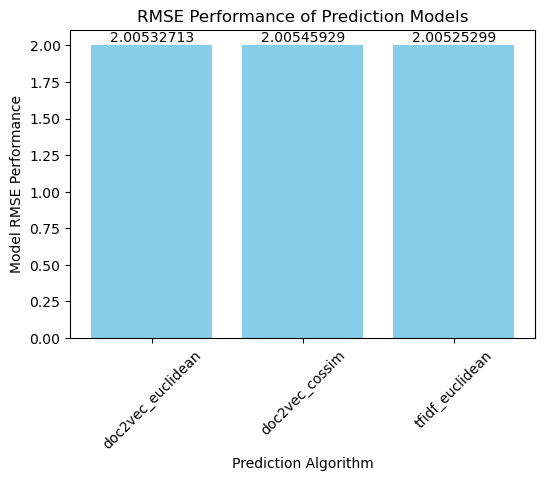

In [49]:
import matplotlib.pyplot as plt

pd.set_option('display.precision', 10)
prediction_algorithm = result_evaluation['Prediction_Algorithm']
rmse_performance = result_evaluation['RMSE_Performance']
plt.figure(figsize=(6, 4))  
bars = plt.bar(prediction_algorithm, rmse_performance, color='skyblue')
plt.xlabel('Prediction Algorithm')
plt.ylabel('Model RMSE Performance')
plt.title('RMSE Performance of Prediction Models')
plt.xticks(rotation=45)
# Adding Y value annotations to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 8), va='bottom', ha='center')
# Display the plot
plt.show()

#### 4.4 - Hyperparameter Optimization:

**Since TF-IDF technically yields the lowest RMSE, I have opted to use TF-IDF for word embeddings and explore various hyperparameters to optimize the model's performance. I evaluated three different algorithms—Cosine similarity, Euclidean distance, and Manhattan distance—to calculate the distances between news articles in the vector space. I did not employ GridSearchCV to search for the best hyperparameters because the Gensim package, which provides the Doc2Vec and Word2Vec libraries, does not implement a function required by GridSearchCV. Therefore, I needed to conduct the evaluation using my own code. The results of the hyperparameter optimization evaluation are as follows:**

In [54]:
result_evaluation_tfidf_metric = pd.DataFrame(columns=['Dataset_Object', 'RecSys_Object', 'TFIDF_Metric',  'RMSE_Performance'])

metric = ['cosine', 'euclidean', 'manhattan']

for i, m in enumerate(metric):
    cf = Collaborative(sample_data)
    cf.calc_item_item_similarity(cf.tfidf_metric, m)  
    yp = cf.predict()
    rmse = cf.rmse(yp)
    print('Training Collaborative Filtering TFIDT with ', m, ' model.  RMSE is ', rmse)
    
    row = pd.DataFrame({
        'Dataset_Object': ['sample_data'],
        'RecSys_Object': [cf],
        'TFIDF_Metric': [m],
        'RMSE_Performance': [rmse]
    })
    result_evaluation_tfidf_metric = pd.concat([result_evaluation_tfidf_metric, row], ignore_index=True)
del cf

C:\Users\wilso\AppData\Local\Temp\ipykernel_5792\393220583.py:44: RuntimeWarning: invalid value encountered in scalar divide
  rating = weighted_rating / weighted_count


Training Collaborative Filtering TFIDT with  cosine  model.  RMSE is  2.0052552170071056


C:\Users\wilso\AppData\Local\Temp\ipykernel_5792\1310274513.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_evaluation_tfidf_metric = pd.concat([result_evaluation_tfidf_metric, row], ignore_index=True)


Training Collaborative Filtering TFIDT with  euclidean  model.  RMSE is  2.005252992208637
Training Collaborative Filtering TFIDT with  manhattan  model.  RMSE is  2.0052612654210686


**The following table summarizes the RMSE of the models with different hyperparameters. Once again, their performances are almost identical, with differences small enough to be negligible. To be precise, Cosine similarity has the lowest RMSE 2.0052552170, making the best performing model for this news article recommendation problem the one utilizing TF-IDF vectorization with Cosine Similarity.**  

In [55]:
result_evaluation_tfidf_metric

,Dataset_Object,RecSys_Object,TFIDF_Metric,RMSE_Performance
0,sample_data,<__main__.Collaborative object at 0x000002213C...,cosine,2.0052552170
1,sample_data,<__main__.Collaborative object at 0x000002213C...,euclidean,2.0052529922
2,sample_data,<__main__.Collaborative object at 0x000002213C...,manhattan,2.0052612654


### 4.5 - Model Improvement & Conclusion

**Based on my experience and the results, I have the following observations:**

- Cold Start: None of the models I trained seem to perform particularly well due to the cold start problem. The fundamental issue here is that the majority of users in the dataset have only a few clicks on news articles, with many having just one click. Although I used 30,000 rows of click records to train the machine learning models, the number of clicks, which are translated into ratings, is too small compared to all the unrated news articles in the dataset. The limited number of clicks does not provide enough data for the model to identify patterns and learn effectively.
- The situation worsens when my laptop lacks sufficient resources for training the model. It frequently throws exceptions due to its inability to allocate enough memory for the large matrices involved in the computation. This significantly impacts my productivity, as I must frequently clear memory or restart my laptop to resume modeling training. 

**To further enhance the news recommendation modeling, several potential actions can be considered:**
- Accessing the full text of news articles would greatly improve the effectiveness of news similarity computation. Unfortunately, the original dataset only provides titles and abstracts of the news articles. Although URLs to the source articles are included, most, if not all, of these links are broken due to the closure of the original competition or workshop associated with the dataset release. It may be possible to find these articles online. If so, incorporating the full text of the articles would enable a more comprehensive vector space and potentially enhance similarity matching between news articles.
- Utilizing Doc2Vec to vectorize the full text of news articles would likely improve model performance. Encoding full-text articles with Doc2Vec could capture all the content and subjects covered in the news articles. The inclusion of more details could lead to more nuanced similarity matching between articles. However, in cases where full text is unavailable, using the abstract for word embedding remains a viable option.
- Leveraging other columns in the news table, such as category, subcategory, entity, and entity relationship, could provide additional valuable information about the content subjects covered in the news articles. Incorporating this metadata, along with Doc2Vec vectors from full text, would offer the best chance of accurately matching similar articles.
- Upgrading to a more powerful computer could be beneficial. With increased processing power, handling larger datasets in the processing pipeline becomes more feasible. Additionally, practicing efficient resource management in coding, such as explicitly deleting variables when they're no longer needed, can help optimize resource utilization. 